# Binary classification using _ImaGene_

This is a short tutorial to learn the basic usage of _ImaGene_ which contains a series of objects in python to interact with the populat package for deep learning _keras_.
In this example our aim is to predict whether a given locus is under natural selection from population genomic data. 
Therefore, we will employ _ImaGene_ to perform a binary classification and we will use the classic example of positive selection for lactase persistence in human populations.

The C/T(-13910) variant, or rs4988235, is located on chromosome 2 in the _MCM6_ gene but influences the lactase _LCT_ gene. This SNP is associated with the primary haplotype associated with lactose intolerance in European populations. 
In these populations, the common T allele is associated with lactase persistence. Individuals who are homozygous for C allele are likely to be lactose intolerant. 
We extracted SNP information from a region of 80k base pairs around the target variant rs4988235 from the 1000 Genomes Project data for all unrelated individuals of CEU population (of European descent).
The data is in the form of a VCF file.

In this tutorial, you will learn how to:
1. read data from VCF file and store it into _ImaGene_ objects,
2. run and process simulations to be used for training,
3. implement, train and evaluate the neural network,
4. deploy the trained network on your genomic data of interest.

Before starting, we need to load the necessary modules in _python_

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model 

Using TensorFlow backend.


and _ImaGene_.

In [2]:
%run -i ../ImaGene.py

Make sure you created a virtual environment with all dependencies as requested. See the main README.md page. Additionally please note that this tutorial has been tested with:
* python 3.6.10
* numpy 1.18.1
* scipy 1.4.1 
* keras 2.3.1
* tensorflow 2.1.0
* scikit-image 0.16.2
* scikit-learn 0.22.1
* matplotlib 3.1.3
* pydot 1.4.1 
* pymc3 3.8
* ipython 7.13.0
* jupyter 1.0.0

### 1. read data from VCF file and store it into _ImaGene_ objects

We store the information of the genomic data into an _ImaFile_ object where we specify the name of the VCF file and the number of samples (i.e. the number of chromosomal copies, twice the number of individuals for a diploid organism).
The latter parameter is not strictly necessary but it is useful to check whether the VCF we are analysing contains the data that we expect.

In [3]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')

We create an _ImaGene_ object by reading the VCF file and generating a matrix of haplotypes.

In [4]:
gene_LCT = file_LCT.read_VCF()

An _ImaGene_ has a series of useful methods. 
For instance, we can have a quick look at the data stored in this object.

In [5]:
gene_LCT.summary()

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


0

As expected, we have one image with 198 rows (equivalent to the number of sampled chromosomal copies) and 2200 columns representing all genomic positions reported.
It is likely that not all of these positions will be polymorphic in the CEU sample as the VCF file reports variats across all analysed populations.

Similarly, we may want to discard rare variants as they may be more associated to errors or be less informative of the scenario we want to predict.
Assume that we want to ignore monomorphic sites and singletons for the derived allele.
We can accomplish this with the following command.

In [6]:
gene_LCT.filter_freq(0.01)

0

If we are unsure about the ancestral/derived polarisation of alleles, we can convert them into major/minor alleles using the method `.majorminor()`. 
We can have a look at the resulting image.

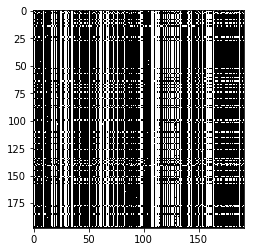

0

In [7]:
gene_LCT.plot()

As the order on the rows is arbitrary, we can order them (and columns) following several criteria.
We can do this with _ImaGene_ with the `.sort` method which has the following options.

In [8]:
gene_LCT.sort?

Assume that we wish to sort only rows by their frequency (with the most frequent haplotypes on the top).
This can be done with the following command (which will also visualise the resulting image).

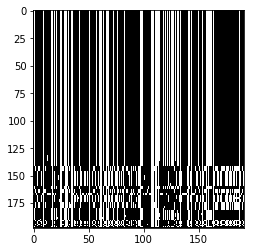

0

In [9]:
gene_LCT.sort('rows_freq')
gene_LCT.plot()

Once we are happy with our data processing (e.g. filtering and sorting), we need to convert the image into an appropriate format which will be later used for the prediction.
As an illustration, we also flip black and white pixels to assign the former to derived (or minor) alleles which is the standard representation of genomic data.

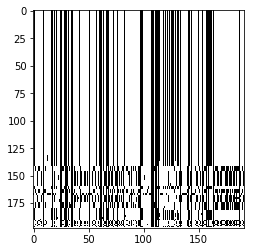

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

In [10]:
gene_LCT.convert(flip=True)
gene_LCT.plot()
gene_LCT.summary()

We finally note that our image has 192 columns now, representing the number of retained SNPs.

We can save our _ImaGene_ object (and load it).
It is useful at this stage to set up some variables to handle the directories where we want to save our data.
For instance, in my case I would set this path:

In [11]:
# change to your path
path = '/home/mfumagal/Data/ImaGene/Tutorials/'

and then I will assume that this data will be saved in the folder `/home/mfumagal/Data/ImaGene/Tutorials/Data`.
Please make sure you have already created these folders, for instance with the `import os` and `os.makedirs(path)` or with `import subprocess` and `subprocess.call("mkdir -p ... ")`.
After this, I can easily save my data in the desired (already created) folder.

In [12]:
# save
gene_LCT.save(file= path + 'Data/gene_LCT_binary')

0

In [13]:
# load
gene_LCT = load_imagene(file=path + 'Data/gene_LCT_binary')

### 2. run and process simulations to be used for training the neural network

_ImaGene_ provides users with an easy interface with _msms_ to run simulations which will be used for training the network.
The script `../generate_dataset.sh` accepts an input file which specifies the parameters of the simulations.
A generic file with all descriptions is `../params.txt`.
If you want to make changes, you need to open the parameter file with a [text editor](https://en.wikipedia.org/wiki/Text_editor), change the value of the desired options, save and close it.

We provide an example of this file called `params_binary` which simulates a total of 200,000 loci of 80kbp either under neutral evolution or positive selection with additive effect and an allelic selection coefficient of $1.5$% targeting a variant in the middle of the region.
Selection started 800 generations ago (corresponding to 20kya with a generation time of 25 years) with an allele frequency of $0.01$.
We impose a mutation rate is $1.5e-8$ per base per generation and a recombination rate of $1e-8$.
Finally, the simulated population follows a 3-epoch model of bottleneck and expansion as proposed by [Marth et al. 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1470693/) for a European population.
We sampled 198 chromosomal copies to match our observed data.

It is __IMPORTANT__ you modify the `params_binary` to specify the directories for _msms_ and the folder where all the simulations will be stored.
These variabiles are set in the first two lines of the file, currently set as:
`DIRMSMS="/home/mfumagal/Software/msms/lib/msms.jar" # path to msms.jar`
and
`DIRDATA="/home/mfumagal/Data/ImaGene/Tutorials/Binary" # path to data storage`
Change them accordingly, save and close the file.

After this, we can run the following command to perform the simulations. This script will split the simulations into different batches to later perform training with a "simulation-on-the-fly" approach.

In [14]:
import subprocess
subprocess.call("bash ../generate_dataset.sh params_binary.txt".split())

0

Let's perform the first iteration of training.
To do that, we need to read the first batch of simulations in `[..]/Binary/Simulations1`and store them into an _ImaFile_ object.

In [15]:
file_sim = ImaFile(simulations_folder=path + 'Binary/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU')

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain. 
As a quick example, we will use only 2000 data points per class.

In [16]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

We can have a look at the data stored in this object.

In [17]:
gene_sim.summary()

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 117, max 480, mean 294.143500, std 64.561985


0

We have 4000 images in this object. Recall that with the first line we simulated 2 classes and retained 2000 data points for each class. All images have 198 rows as expected, as this represents the number of simulated haplotypes. However, images have different number of columns, ranging from $\approx 130$ to $\approx 450$ with an average value of $\approx 295$. The number of columns represents the number of polymorphic sites and fixed derived alleles in a _msms_ file. This number may vary from simulated gene to another.
Our observed data for LCT has 192 columns.

As mentioned before, _ImaGene_ provides functionalities to manipulate our data. Specifically we can do the following:
* convert ancestral/derived to major/minor allele polarisation
* filter out columns based on a minimum allele frequency (e.g. 0.01)
* sorting rows and columns by frequency (or genetic distance from the most frequent entry)

We need to follow the same data processing as the one employed for the real data.

In [18]:
gene_sim.filter_freq(0.01)
gene_sim.sort('rows_freq')
gene_sim.summary()

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 60, max 369, mean 218.065750, std 53.173776


0

All images must have the same dimensions. You can explore all different options for resizing.

In [19]:
?gene_sim.resize

One possibility would be to resize them to match the dimensions of the real data.
In this case it means resize all images to have shape (198, 192) which can be achieved with the following command.

In [20]:
gene_sim.resize((198, 192))
gene_sim.summary()

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

After the data manipulation is done, we need to convert images to proper _numpy_ float matrices,as previously discussed. The following line will do the job (including flipping black/white pixels). 
Note that the `.convert` method allows you to normalise the data too.

In [21]:
gene_sim.convert(flip=True)
gene_sim.summary()

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

Note that in addition to the genomic data, an _ImaGene_ object contains information on the corresponding targets (in this case the selection coefficient, either 0 or 300 in $2N_e$ units with $N_e = 10000$).
As an illustration, let's plot one random image per class.

0


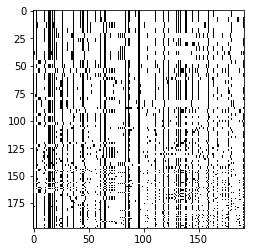

300


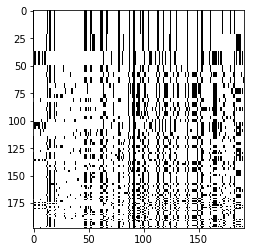

In [22]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

Finally we need to randomly shuffle our images before using them for training our network.
We can easily accomplish this with the following line.

In [23]:
gene_sim.subset(get_index_random(gene_sim))

0

Our targets represent the 2 possible classes. However, since we are doing a binary classification, we need to vectorise them as required by _keras_.

In [24]:
gene_sim.targets = to_binary(gene_sim.targets)

The object is now ready to be used for the classification!
You can save it.

In [25]:
gene_sim.save(file=path+'Data/gene_sim.binary')

0

If you want to load an _ImaGene_ object you can use the following function.

In [26]:
gene_sim = load_imagene(file=path+'Data/gene_sim.binary')

### 3. implement, train and evaluate the neural network

Now that our data is ready, we can build our network.
Specifically, we can build a model in _keras_ with convolutional, pooling and dense layers.
In this example we have 3 layers of 2D convolutions and pooling followed by a fully-connected layer.
We just need to specify the dimensions of the data in the first layer, and this is specified by the option `input_shape=gene_sim.data.shape[1:]`.

In [27]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

Then, let's compile our _keras_ model.

In [28]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's look at a summary of the model and plot it.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 196, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32384)            

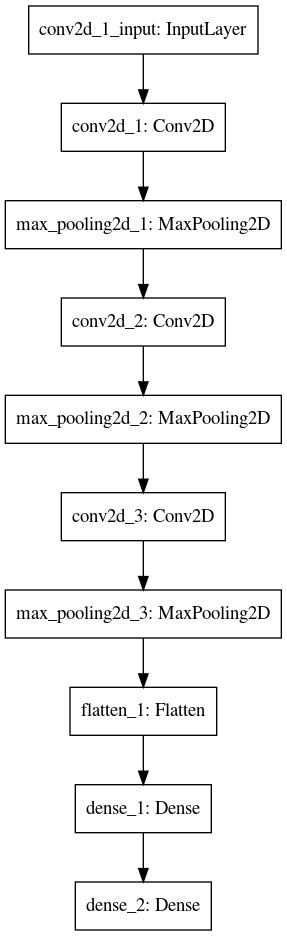

In [29]:
model.summary()
plot_model(model, path+'Data/net.binary.png')

Now we are ready for doing the training on this first batch of data.

In [30]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 74s 21ms/step - loss: 4.8259 - accuracy: 0.5850 - val_loss: 2.9402 - val_accuracy: 0.9550


Remember that you can save a _keras_ model with `model.save('net.h5')`.

Now we can initialise a network object _ImaNet_.

In [31]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

We can keep track of scores (loss and accuracy) across iterations with `.update_scores`.

In [32]:
net_LCT.update_scores(score)

0

Now we need to repeat the whole procedure described above using all remaning batches of data, leaving the last one for testing.

In [33]:
i = 2
while i < 10:

    print(i)
    
    file_sim = ImaFile(simulations_folder=path+'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)
     
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)
    net_LCT.update_scores(score)
   
    i += 1

2
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 80s 22ms/step - loss: 2.2019 - accuracy: 0.7628 - val_loss: 1.6987 - val_accuracy: 0.5875
3
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 78s 22ms/step - loss: 1.1315 - accuracy: 0.8989 - val_loss: 0.9365 - val_accuracy: 0.8875
4
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 84s 23ms/step - loss: 0.7002 - accuracy: 0.9439 - val_loss: 0.5098 - val_accuracy: 0.9800
5
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 83s 23ms/step - loss: 0.4972 - accuracy: 0.9583 - val_loss: 0.3839 - val_accuracy: 0.9875
6
Train on 3600 samples, validate on 400 samples
Epoch 1/1
3600/3600 [==============================] - 85s 24ms/step - loss: 0.4020 - accuracy: 0.9614 - val_loss: 0.3627 - val_accuracy: 0.9725
7
Train on 3600 samples, valid

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

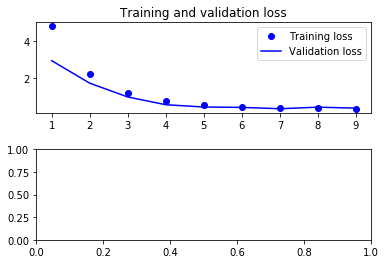

In [34]:
net_LCT.plot_train()

In [35]:
net_LCT.scores

{'acc': [],
 'loss': [[4.825934980180528],
  [2.2019344160291885],
  [1.1315286919805738],
  [0.7002292442321777],
  [0.4971641947163476],
  [0.4019806603590647],
  [0.33171722094217937],
  [0.3015414696269565],
  [0.2826480093267229]],
 'mae': [],
 'val_acc': [],
 'val_loss': [[2.9402130126953123],
  [1.6986887168884277],
  [0.9365378665924072],
  [0.5098069381713867],
  [0.3839496052265167],
  [0.36266589403152466],
  [0.28874035358428957],
  [0.37506240129470825],
  [0.32109720289707183]],
 'val_mae': []}

In [37]:
score.history

{'accuracy': [0.9672222],
 'loss': [0.2826480093267229],
 'val_accuracy': [0.9574999809265137],
 'val_loss': [0.32109720289707183]}

We save (and/or load) the final trained model.

In [ ]:
model.save(path+'Data/model.binary.h5')

In [ ]:
# load
model = load_model(path+'Data/model.binary.h5')

You can also save the network itself (and load it).

In [ ]:
net_LCT.save(path+'Data/net_LCT.binary')

In [ ]:
# load
net_LCT = load_imanet(path+'Data/net_LCT.binary')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [ ]:
i = 10
file_sim = ImaFile(simulations_folder=path+'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets)

Let's report loss and accuracy on the testing set.

In [ ]:
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

In [ ]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)

### 4. deploy the trained network on your genomic data of interest

Finally we can use the trained network to predict natural selection on our locus of interest.
The output of this command will give us the class score (e.g. this can be interpreted as a posterior probability with uniform prior, or scaled likelihood) of said locus under positive selection under the conditions we simulated.

In [ ]:
model.predict(gene_LCT.data, batch_size=None)[0][0]